# Cairo Periodic Boundaries

    In this script, I will compute a Cairo lattice simulation but with periodic boundaries in order to observe if the evolution of charges is preserved with those. 

In [1]:
import os
import sys
import numpy as np
from importlib import reload  
import support as sup
reload(sup)
sys.path.insert(0, '../icenumerics')

import icenumerics as ice

from icenumerics.geometry import ordering 
import magcolloids as mgc

import matplotlib.pyplot as plt
ureg = ice.ureg
from string import Template

%load_ext autoreload
%autoreload 2

In [2]:
output = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-8.0"

    To set correctly periodic boundaries I need to build a Cairo lattice but with a square structure. This way there will be a match of the vertices by only translating the lattice a certain quantity. To do that I need to re-draw the lattice. Let's start! 

In [3]:
np.random.seed()

l = 6
a = 19.5458*ureg.um
sp = sup.spins()
ureg = ice.ureg
sp.create_lattice(geometry = "cairo",size =[l,l],lattice_constant=19.5458*ureg.um, border="periodic")
sp.order_spins(ordering.random_ordering)

/home/carolina/CairoLattice_ACI_PROJECT/Scripts/support.py:283: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_centers[:,1] = centersY


In [4]:
particle = ice.particle(radius = 5*ureg.um,
             susceptibility = 0.005,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap_long = ice.trap(trap_sep = 10*ureg.um,
               height = 30*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

trap_short = ice.trap(trap_sep = 4.5258*ureg.um,
               height = 30*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

traps = []

In [5]:
for s in sp:
    
    if ( s.direction[0].magnitude == a.magnitude or s.direction[0].magnitude == -a.magnitude or 
        s.direction[1].magnitude == a.magnitude or s.direction[1].magnitude == -a.magnitude ):
        
        traps.append(trap_short)
        
    else:
        
        traps.append(trap_long)

In [6]:
col = ice.colloidal_ice(sp, particle, traps, height_spread = 0, susceptibility_spread = 0.1)

col.pad_region(0*ureg.um)

In [7]:
world = ice.world(
    field = 25*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um,
   boundaries = ["p", "p", "p"])

In [8]:
total_time = 100*ureg.s
col.simulate(world,
             name = "ACI_CairoLattice_l%u_15mT-800s"%(l),
             include_timestamp = False,
             targetdir = output,
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

scanning file


In [9]:
col.sim.field.fieldz = "v_Bmag"
col.run_simulation()

In [10]:
col.load_simulation(slice(0,None,1))

scanning file


In [24]:
from matplotlib import patches

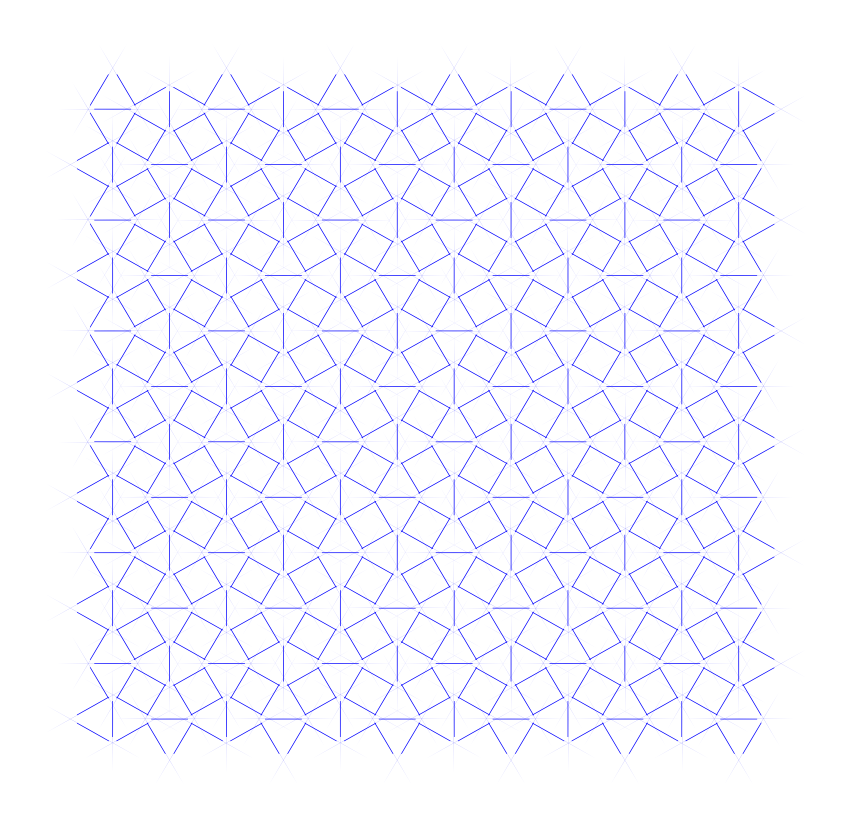

In [53]:

f, (ax1) = plt.subplots(1,1,figsize = (15,15))
for c in col:
    #print(c.center)

        
    X=c.center[0].magnitude
    Y=c.center[1].magnitude
    DX=c.direction[0]*0.3
    DY=c.direction[1]*0.3
    W = np.sqrt(DX**2+DY**2)
    c.width = W
    ax1.plot([X],[Y],'b')
    #ax1.plot([X-DX,X+DX],[Y-DY,Y+DY],'-+')
    ax1.add_patch(patches.Arrow(X-DX,Y-DY,2*DX,2*DY,width=W*500,fc='blue'))
plt.axis('off')
plt.savefig('lattice.png', dpi=1200)

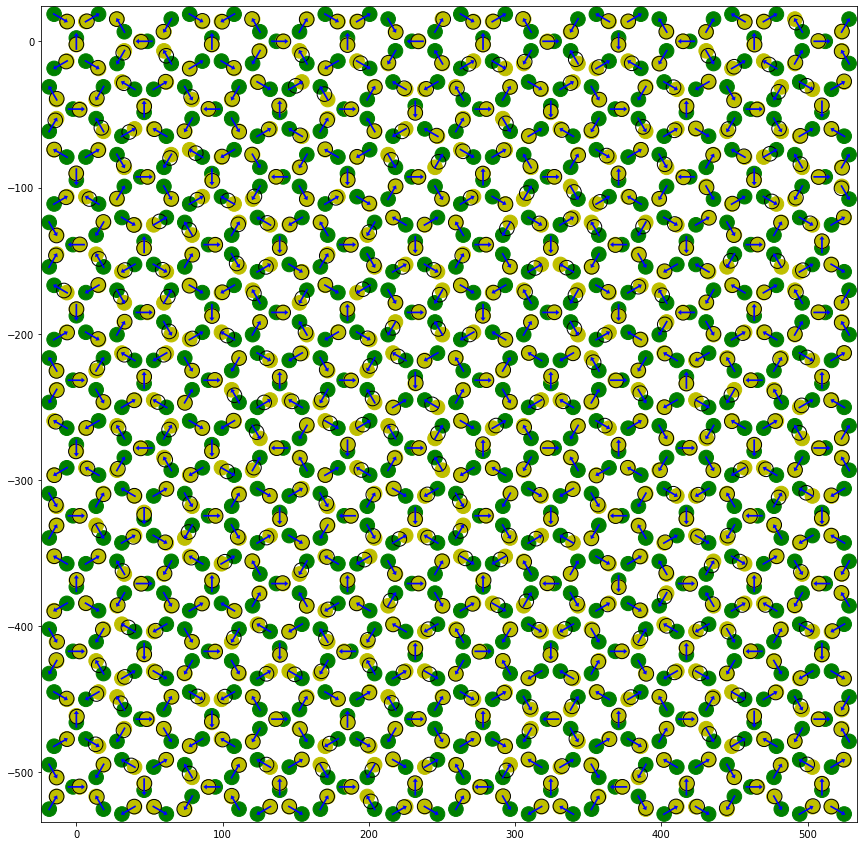

In [14]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))
col.set_state_from_frame(-1)
col.display(ax1)
sp.display(ax1)

,x,y,coordination,dx,dy
charge,,,,,
-2,15,15,15,15,15
-1,151,151,151,151,151
0,131,131,131,131,131
1,134,134,134,134,134
2,18,18,18,18,18
3,3,3,3,3,3
4,1,1,1,1,1


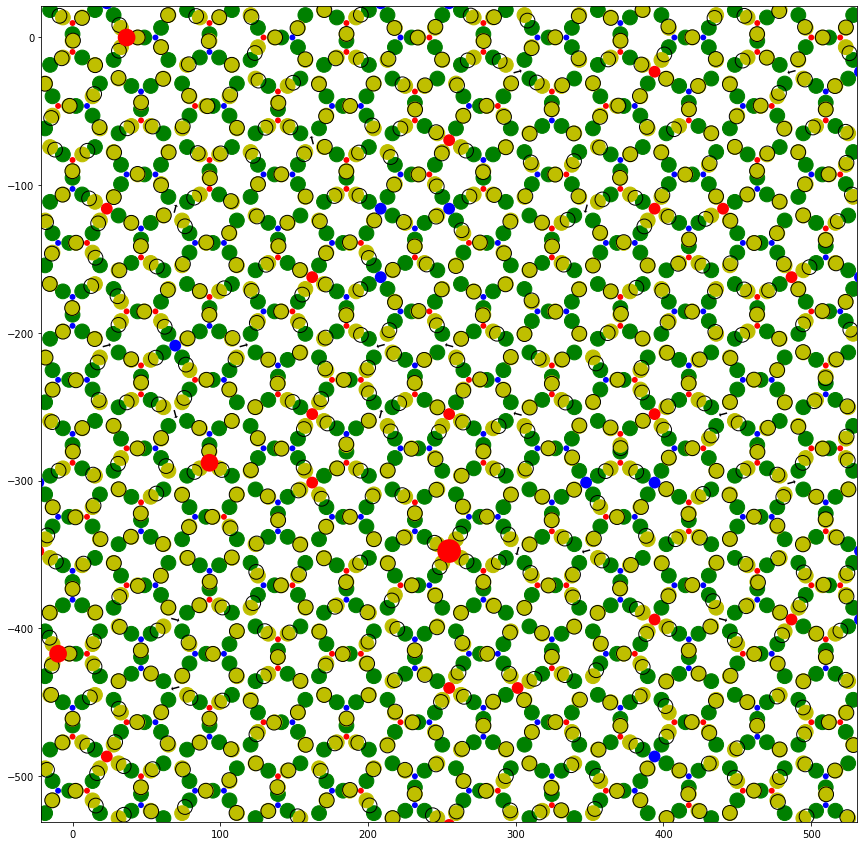

In [13]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))
v = ice.vertices()
col.set_state_from_frame(-1)
v = v.colloids_to_vertices(col)

col.display(ax1)
v.display(ax1)
v.vertices.groupby('charge').count()

    It works!!!